# PRiAD - Projekt zespołowy "Klasyfikacja wniosków kredytowych"

---

In [1]:
# Import potrzebnych bibliotek
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

# Zmiana sposobu wyświetlania danych zmiennoprzecinkowych
pd.options.display.float_format = "{:.2f}".format 

In [2]:
# Przydatne funkcje

def setProperColumnNames(data):
    data = data.rename(
        columns = {
            0:'A1', 1:'A2', 2:'A3', 3:'A4', 4:'A5', 5:'A6', 6:'A7', 7:'A8', 8:'A9',
            9:'A10', 10:'A11', 11:'A12', 12:'A13', 13:'A14', 14:'A15', 15:'A16'
        }
    )
    
    return data

def getErrorMatrix(data, testResult):
    return pd.crosstab(data['decisiveSetToTest'], testResult) 


def getTotalErrors(errorMatrix):
    totalErrors = 0

    # Błędy nad diagonalą
    for row in range(0, errorMatrix.shape[0]):
        for column in range(row + 1, errorMatrix.shape[1]):
            totalErrors += errorMatrix.iloc[row, column]

    # Błędy pod diagonalą
    for column in range(0, errorMatrix.shape[1]):
        for row in range(column + 1, errorMatrix.shape[0]):
            totalErrors += errorMatrix.iloc[row, column]

    return totalErrors


# 1. Przygotowanie danych.

Wczytanie i przygotowanie ramki danych do pracy:

In [3]:
# Konwersja .data --> .csv do typu Data Frame
rawData = pd.read_csv('crx.data', header = None, sep = ',')
rawData = setProperColumnNames(rawData)

# Porzucenie wierszy z podziurawionymi danymi
rawData = rawData.dropna()
for column in rawData.columns:
    rawData = rawData[rawData[column] != '?']

rawData

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.50,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.54,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.62,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.09,y,p,e,h,1.25,f,f,0,f,g,00260,0,-
686,a,22.67,0.75,u,g,c,v,2.00,f,t,2,t,g,00200,394,-
687,a,25.25,13.50,y,p,ff,ff,2.00,f,t,1,t,g,00200,1,-
688,b,17.92,0.20,u,g,aa,v,0.04,f,f,0,f,g,00280,750,-


In [4]:
# Oddzielenie modyfikowanego zbioru danych od czystego
data = rawData


Aby otrzymać wiarygodne wyniki podczas pracy nad danymi musimy je ustandaryzować, a do tego musieliśmy je odpowiednio zakodować. Zamieniliśmy znaki i łańcuchy znaków w danych na wartości liczbowe. Następnie ustandaryzowaliśmy nasze dane, aby nie zatruć klasyfikatora przez duże różnice w zakresach przyjmowanych wartości poszczególnych atrybutów:

In [5]:
# Zakodowanie danych
columnsToEncodeIndexes = [1, 4, 5, 6, 7, 9, 10, 12, 13, 16]
for index in columnsToEncodeIndexes:
    data['A' + str(index)] = data['A' + str(index)].astype('category').cat.codes

data

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,30.83,0.00,1,0,12,7,1.25,1,1,1,0,0,00202,0,0
1,0,58.67,4.46,1,0,10,3,3.04,1,1,6,0,0,00043,560,0
2,0,24.50,0.50,1,0,10,3,1.50,1,0,0,0,0,00280,824,0
3,1,27.83,1.54,1,0,12,7,3.75,1,1,5,1,0,00100,3,0
4,1,20.17,5.62,1,0,12,7,1.71,1,0,0,0,2,00120,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.08,10.09,2,2,4,3,1.25,0,0,0,0,0,00260,0,1
686,0,22.67,0.75,1,0,1,7,2.00,0,1,2,1,0,00200,394,1
687,0,25.25,13.50,2,2,5,2,2.00,0,1,1,1,0,00200,1,1
688,1,17.92,0.20,1,0,0,7,0.04,0,0,0,0,0,00280,750,1


In [6]:
# Standaryzacja danych
sc = StandardScaler()

data = sc.fit_transform(data)
data = pd.DataFrame(data)  
data = setProperColumnNames(data)

data

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,0.67,-0.06,-0.96,-0.54,-0.55,1.45,0.77,-0.30,0.93,1.13,-0.30,-0.93,-0.30,0.13,-0.19,-1.10
1,-1.49,2.30,-0.07,-0.54,-0.55,0.98,-0.84,0.24,0.93,1.13,0.70,-0.93,-0.30,-0.82,-0.09,-1.10
2,-1.49,-0.59,-0.86,-0.54,-0.55,0.98,-0.84,-0.22,0.93,-0.89,-0.50,-0.93,-0.30,0.59,-0.04,-1.10
3,0.67,-0.31,-0.65,-0.54,-0.55,1.45,0.77,0.45,0.93,1.13,0.50,1.08,-0.30,-0.48,-0.19,-1.10
4,0.67,-0.96,0.16,-0.54,-0.55,1.45,0.77,-0.16,0.93,-0.89,-0.50,-0.93,3.35,-0.36,-0.19,-1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,0.67,-0.88,1.05,1.80,1.81,-0.41,-0.84,-0.30,-1.07,-0.89,-0.50,-0.93,-0.30,0.47,-0.19,0.91
649,-1.49,-0.75,-0.81,-0.54,-0.55,-1.11,0.77,-0.07,-1.07,1.13,-0.10,1.08,-0.30,0.12,-0.12,0.91
650,-1.49,-0.53,1.73,1.80,1.81,-0.18,-1.24,-0.07,-1.07,1.13,-0.30,1.08,-0.30,0.12,-0.19,0.91
651,0.67,-1.15,-0.92,-0.54,-0.55,-1.34,0.77,-0.65,-1.07,-0.89,-0.50,-0.93,-0.30,0.59,-0.05,0.91


# 3. Utworzenie zbioru uczącego i testowego.

Podzielmy otrzymany zbiór danych wniosków kredytowych na zbiór testowy oraz uczący tak, aby zbiór uczący był dwa razy większy od testowego. Dzięki takiej proporcji otrzymamy najbardziej wiarygodny wynik wydajności budowanego klasyfikatora:

In [7]:
# Podział na zbiór testowy/uczący po atrybutach opisowych/decyzyjnych:
proportion = 0.33

descriptiveSetToTeach, descriptiveSetToTest, decisiveSetToTeach, decisiveSetToTest = train_test_split(
    data.iloc[:,0:-1], 
    data.iloc[:,-1].astype('category').cat.codes, 
    test_size = proportion
)

dividedData = {
    'descriptiveSetToTeach' : descriptiveSetToTeach, 
    'descriptiveSetToTest' : descriptiveSetToTest, 
    'decisiveSetToTeach' : decisiveSetToTeach, 
    'decisiveSetToTest' : decisiveSetToTest
}


# 4. Próbna budowa klasyfikatora i klasyfikacja.

W ramach naszego klasyfikatora przetestowaliśmy poniższe:
* K Nearest Neighbors
* Nearest Centroid
* Gaussian Naive Bayes
* Random Forest Classifier 

Klasyfikator k najbliższych sąsiadów okazał się najskuteczniejszy, ponieważ:
* Osiągał największy wynik procentowy poprawnie zklasyfikowanych wnioskow kredytowych
* Z innych klasyfikatorów o podobnych wynikach (Najbliższego Centroidu) w przeciągu kilkunastu uruchomień wynik procentowy poprawnie zklasyfikowanych wniosków kredytowych wahał się najmniej

Dla wybranego klasyfikatora zastanowiliśmy się nad najlepszymi możliwymi jego parametrami. 
* Sprawdziliśmy kolejne nieparzyste wartości k = 3, 5, 7, 9, 11. Najlepszym i najbardziej stabilnym wynikiem (na tle kilkunastu wywołań) cieszyło się k = 5.  
* Po próbach testów kolejno przyjętych metryk odległości (euklidesowa, manhattan, chevyshev, minkowski etc.) najlepszą okazała się 'minkowski'. 
* Podobnie postąpiliśmy z algorytmami - najlepsze (na podobnym poziomie) okazały się algorytmy 'ball_tree' oraz 'brute', więc na podstawie złożoności czasowej wybraliśmy 'ball_tree' jako ten bardziej optymalny.

In [8]:
# Zbudowanie klasyfikatora
classifier = KNeighborsClassifier(
    n_neighbors = 5, 
    algorithm = 'ball_tree', 
    metric = 'minkowski'
)

classifier.fit(
    dividedData['descriptiveSetToTeach'], 
    dividedData['decisiveSetToTeach']
)


KNeighborsClassifier(algorithm='ball_tree')

Po zbudowaniu klasyfikatora wykonujemy klasyfikację próbną, a następnie wyświetlamy jej wynik w postaci macierzy błędów oraz procentu poprawnie zaklasyfikowanych wektorów. Na podstawie tego będziemy w stanie ocenić skuteczność zbudowanego przez nas klasyfikatora.

In [9]:
# Wykonanie klasyfikacji
testResult = classifier.predict(
    dividedData['descriptiveSetToTest']
)


In [10]:
# Wyświetlenie wyniku pracy klasyfikatora
testErrorMatrix = getErrorMatrix(dividedData, testResult)

print('Mistakes matrix for test set (0 = \'+\', 1 = \'-\'):')
print(testErrorMatrix)

totalErrors = getTotalErrors(testErrorMatrix)
print('Number of mistakes: %d' % totalErrors)

accuracy = accuracy_score(dividedData['decisiveSetToTest'], testResult)
print('Accuracy: ', accuracy)


Mistakes matrix for test set (0 = '+', 1 = '-'):
col_0   0    1
row_0         
0      76   22
1       8  110
Number of mistakes: 30
Accuracy:  0.8611111111111112


Skuteczność na poziomie 90% wydaje się być poprawna, ale w tak wrażliwym obszarze jakim jest bankowość jest zdecydowanie zbyt niska. Aby podnieść skuteczność klasyfikacji danych przeprowadzimy analizę eksploracyjną, która wyłoni czy poszczególne pojedyncze atrybuty są w stanie wskazać wynik klasyfikacji bardziej niż pozostałe.

# 5. Analiza eksploracyjna danych.

Zacznijmy od przeprowadzenia badanie korelacji poszczególnych atrybutów, z których być może uda się wyłonić atrybuty nadmiarowe:

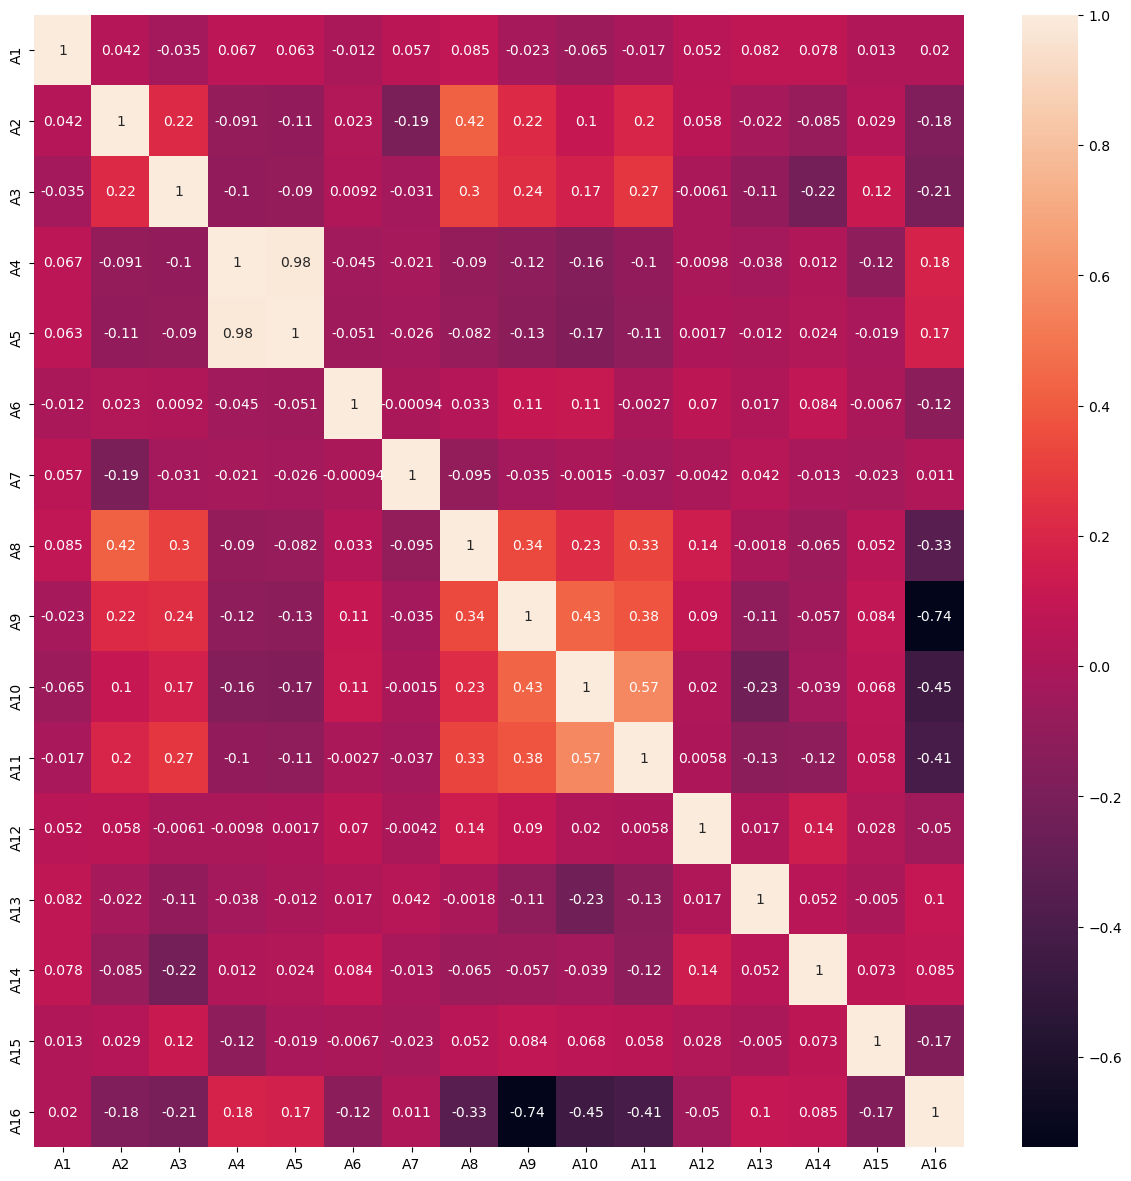

In [18]:
# Budowa macierzy korelacji atrybutów
dataCorr = data.corr()

# Wyświetlenie macierzy korelacji
plt.figure(figsize = (15,15), dpi = 100)
sns.heatmap(dataCorr, annot = dataCorr)

Z przeprowadzonej analizy macierzy korelacji pomiędzy atrybutami możemy wysunąć następujące wnioski:
* Najbardziej silne skorelowane ze sobą pary atrybutów:
    * {A4, A5}     -> 0.98
    * {A9, A16}    -> - 0,74
    * {A10, A11}   -> 0.57
* Nie oznacza to wcale logicznego z punktu biznesowego powiązania pomiędzy tymi atrybutami w obie strony. Najczęściej to jeden atrybut z każdej pary definiuje drugi, ale drugi wcale nie definiuje pierwszego. Problem polega na prawidłowej ocenie, którego nadmiarowego atrybutu możemy się pozbyć z procesu kwalifikacji. 
* Ponieważ tytuły atrybutów zostały zakodowanego w celu zachowania poufności ich prawdziwej tożsamości nie jesteśmy w stanie stwierdzić, który jest skutkiem którego. 
* Z racji bardzo wysokiej korelacji atrybutów A4 i A5 możemy w przybliżeniu założyć, że są tak bardzo zależne od siebie, że nie ma aż takiego znaczeni, który jest skutkiem którego. Oznacza to, że możemy pozbyć się jednego z nich bez potrzeby znajomości jego prawdziwej tożsamości. Decyzję podejmiemy na podstawie wartości korelacji obu atrybutów z pozostałymi atrybutami danych i pozbędziemy się tego, którego korelacje przyjmują największe wartości.
* Po zakończeniu analizy zakładamy, że będziemy mogli pozbyć się atrybutu A4 i poprawi to wynik klasyfikacji.


Narysujmy teraz wykresy przedstawiające wynik klasyfikacji w zakresie przyjmowanych wartości poszczególnych atrybutów:

In [ ]:
# Histograms for eaach of the columns
feature_dict = {i:label for i,label in zip(
                range(14), dataset.columns)}

label_dict = {0: 'Rejected', 1: 'Approved'}
import math

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10,10))

for ax,cnt in zip(axes.ravel(), range(14)):

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plotting the histograms
    for lab,col in zip(range(0,2), ('red', 'blue')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Credit histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()
plt.show()

Wnioski:
* 
* 
* 

Najważniejsze atrybuty przy kwalifikacji:
* 
* 
* 
* 
* 
* 
* 
* 
* 

# 6. Ponowna budowa klasyfikatora i klasyfikacja na podstawie wniosków z analizy eksploracyjnej.

Uwzględnijmy wyłonione podczas analizy najważniejsze atrybuty:

In [ ]:
relevantAtributes = []

Zbudujmy ponownie klasyfikator na podstawie przyjętych atrybutów i od nowa przeprowadźmy klasyfikację zbioru testowego:

In [ ]:
# Zbudowanie klasyfikatora
relevantClassifier = KNeighborsClassifier(
    n_neighbors = 5, 
    algorithm = 'ball_tree', 
    metric = 'minkowski'
)

relevantClassifier.fit(
    dividedData['descriptiveSetToTeach'].iloc[:, relevantAttributes], 
    dividedData['decisiveSetToTeach']
)


Ponowne wykonanie klasyfikacji i wyświetlenie jej wyniku w postaci macierzy błędów oraz procentu poprawnie zaklasyfikowanych wektorów. Na podstawie tego będziemy w stanie ocenić skuteczność zbudowanego przez nas klasyfikatora i przeprowadzonej analizy eksploracyjnej:

In [ ]:
# Wykonanie klasyfikacji
relevantTestResult = relevantClassifier.predict(
    dividedData['descriptiveSetToTest']
)

# Wyświetlenie wyniku pracy klasyfikatora
relevantTestErrorMatrix = getErrorMatrix(dividedData, relevantTestResult)

print('Mistakes matrix for test set (0 = \'+\', 1 = \'-\'):')
print(relevantTestErrorMatrix)

totalErrors = getTotalErrors(relevantTestErrorMatrix)
print('Number of mistakes: %d' % totalErrors)

accuracy = accuracy_score(dividedData['decisiveSetToTest'], relevantTestResult)
print('Accuracy: ', accuracy)


OCENA WYNIKU KLASYFIKACJI

# 7. Podsumowanie.

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.